# Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import sklearn
import librosa
import os
import os.path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
!pip install resampy
import resampy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import librosa.util
from tensorflow.keras.utils import to_categorical

In [ ]:
diagnosis=pd.read_csv('/content/drive/MyDrive/TASK-1/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['Patient Number', 'disease'] )
diagnosis.head(5)

,Patient Number,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


<Axes: xlabel='disease', ylabel='count'>

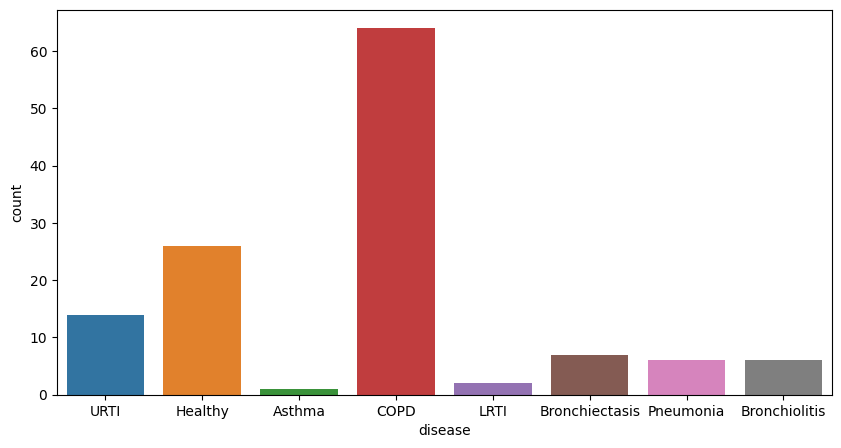

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=diagnosis, x='disease')

In [ ]:
demograph= pd.read_csv('/content/drive/MyDrive/TASK-1/demographic_info.txt', names=['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'], delimiter=' ')
demograph.head(5)

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0


In [ ]:
data=demograph.join(diagnosis.set_index('Patient Number'), on= 'Patient number', how='left')
data.head(5)
data.shape

(126, 7)

In [ ]:
path='/content/drive/MyDrive/TASK-1/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
audio=[t.split('.')[0] for t in os.listdir(path=path) if '.wav' in t]
audio_1=[t for t in os.listdir(path=path) if '.wav' in t]
def extract_audio(file_name, path, audio_1):
  s= file_name.split('_')
  s.append(audio_1[col])
  recording_info=pd.DataFrame(data=[s], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment', 'file'])
  recording_annotations=pd.read_csv(os.path.join(path, file_name+'.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
  return(recording_info, recording_annotations)

i_list = []
rec_annotations = []
for col in range(len(audio)):
    (i,a) = extract_audio(audio[col], path, audio_1)
    i_list.append(i)
    rec_annotations.append(a)
#print(i_list)
recording_info = pd.concat(i_list, axis = 0)
#recording_info.shape
##filenames=pd.DataFrame(data=filenames, columns=['g'])
##audio_files.shape

In [ ]:
recording_info.shape
recording_info=recording_info.sort_values('Patient number')
recording_info.head(2)

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment,file
0,101,1b1,Pr,sc,Meditron,101_1b1_Pr_sc_Meditron.wav
0,101,1b1,Al,sc,Meditron,101_1b1_Al_sc_Meditron.wav


In [ ]:
audio_file_path='/content/drive/MyDrive/TASK-1/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
#audio_data, sample_rate=librosa.load(audio_file_path)
#print(audio_data)

In [ ]:
#file_name= os.path.join(audio_file_path, j['file'])
#audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
#mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
#print(mfccs_features.T)
#mfccs_features

In [ ]:
def audio_feature_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    audio_len_sec = librosa.get_duration(y=audio, sr=sample_rate)

    target_duration = 20  # Desired duration in seconds

    if audio_len_sec < target_duration:
        target_length_samples = int(target_duration * sample_rate)
        padded_audio = librosa.util.pad_center(audio, size=target_length_samples)
    else:
        target_length_samples = int(target_duration * sample_rate)
        padded_audio = audio[:target_length_samples]

    mfccs_features = librosa.feature.mfcc(y=padded_audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

In [ ]:
audio_features=[]
for i, j in tqdm(recording_info.iterrows()):
## here i denotes index label i.e. it will iterate over rows and j will contain all columns of that row.
  file_name= os.path.join(audio_file_path, j['file'])
  final_labels=j['file']
  data=audio_feature_extractor(file_name)
  audio_features.append([data, final_labels])
  #if j['Patient number']==101:
   # print(audio_features)
    #break

920it [05:16,  2.90it/s]


In [ ]:
#audio_features=np.array(audio_features)
#audio_features.dtype
#audio_features=audio_features.reshape([,1]\)
audio_features=pd.DataFrame(audio_features, columns=['audio_features', 'file'])
audio_features.head(2)


,audio_features,file
0,"[-582.509, 95.400894, 57.395645, 31.442133, 28...",101_1b1_Pr_sc_Meditron.wav
1,"[-528.4309, 104.52567, 69.89893, 42.58108, 31....",101_1b1_Al_sc_Meditron.wav


In [ ]:
df=recording_info.join(audio_features.set_index('file'), on= 'file')
df.head(2)

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment,file,audio_features
0,101,1b1,Pr,sc,Meditron,101_1b1_Pr_sc_Meditron.wav,"[-582.509, 95.400894, 57.395645, 31.442133, 28..."
0,101,1b1,Al,sc,Meditron,101_1b1_Al_sc_Meditron.wav,"[-528.4309, 104.52567, 69.89893, 42.58108, 31...."


In [ ]:
df.drop(['file'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 920 entries, 0 to 0
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Patient number       920 non-null    object
 1   Recording index      920 non-null    object
 2   Chest location       920 non-null    object
 3   Acquisition mode     920 non-null    object
 4   Recording equipment  920 non-null    object
 5   audio_features       920 non-null    object
dtypes: object(6)
memory usage: 50.3+ KB


In [ ]:
df['Patient number']= df['Patient number'].astype(int)
df.head(2)

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment,audio_features
0,101,1b1,Pr,sc,Meditron,"[-582.509, 95.400894, 57.395645, 31.442133, 28..."
0,101,1b1,Al,sc,Meditron,"[-528.4309, 104.52567, 69.89893, 42.58108, 31...."


In [ ]:
print(df.shape,'\n')
print(data.shape,'\n')

(920, 6) 

(40,) 



In [ ]:
Patient_details=df.join(data.set_index('Patient number'), on='Patient number')
print(Patient_details.shape,'\n')
Patient_details.head(2)

(920, 12) 



,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment,audio_features,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),disease
0,101,1b1,Pr,sc,Meditron,"[-582.509, 95.400894, 57.395645, 31.442133, 28...",3.0,F,NaN,19.0,99.0,URTI
0,101,1b1,Al,sc,Meditron,"[-528.4309, 104.52567, 69.89893, 42.58108, 31....",3.0,F,NaN,19.0,99.0,URTI


In [ ]:
Patient_details.isnull().sum()

Patient number           0
Recording index          0
Chest location           0
Acquisition mode         0
Recording equipment      0
audio_features           0
Age                      6
Sex                      6
Adult BMI (kg/m2)       85
Child Weight (kg)      851
Child Height (cm)      853
disease                  0
dtype: int64

In [ ]:
Patient_details.drop(['Sex'], axis=1, inplace=True)
Patient_details.drop(['Recording equipment'], axis=1, inplace=True)

In [ ]:
Patient_details.head(2)

,Patient number,Recording index,Chest location,Acquisition mode,audio_features,Age,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),disease
0,101,1b1,Pr,sc,"[-582.509, 95.400894, 57.395645, 31.442133, 28...",3.0,NaN,19.0,99.0,URTI
0,101,1b1,Al,sc,"[-528.4309, 104.52567, 69.89893, 42.58108, 31....",3.0,NaN,19.0,99.0,URTI


In [ ]:
Patient_details['Age']=Patient_details['Age'].fillna(np.mean(Patient_details['Age']))
Patient_details.isnull().sum()

Patient number         0
Recording index        0
Chest location         0
Acquisition mode       0
audio_features         0
Age                    0
Adult BMI (kg/m2)     85
Child Weight (kg)    851
Child Height (cm)    853
disease                0
dtype: int64

In [ ]:
Patient_details['Adult BMI (kg/m2)']=Patient_details['Adult BMI (kg/m2)'].fillna(0)
Patient_details['Child Weight (kg)']=Patient_details['Child Weight (kg)'].fillna(0)
Patient_details['Child Height (cm)']=Patient_details['Child Height (cm)'].fillna(0)

In [ ]:
Patient_details.drop(['Age'], axis=1, inplace=True)
Patient_details.isnull().sum()

Patient number       0
Recording index      0
Chest location       0
Acquisition mode     0
audio_features       0
Adult BMI (kg/m2)    0
Child Weight (kg)    0
Child Height (cm)    0
disease              0
dtype: int64

In [ ]:
Patient_details=Patient_details.astype({'Chest location':'category', 'Acquisition mode':'category', 'disease': 'category'})
Patient_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 920 entries, 0 to 0
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Patient number     920 non-null    int64   
 1   Recording index    920 non-null    object  
 2   Chest location     920 non-null    category
 3   Acquisition mode   920 non-null    category
 4   audio_features     920 non-null    object  
 5   Adult BMI (kg/m2)  920 non-null    float64 
 6   Child Weight (kg)  920 non-null    float64 
 7   Child Height (cm)  920 non-null    float64 
 8   disease            920 non-null    category
dtypes: category(3), float64(3), int64(1), object(2)
memory usage: 53.8+ KB


In [ ]:

le=LabelEncoder()
Patient_details['audio_features']=Patient_details['audio_features'].apply(lambda x: le.fit_transform(x))

In [ ]:
Patient_details['audio_features']=np.array(Patient_details['audio_features'].tolist())
#for i in Patient_details['audio_features']:
  #i=list(i)
print(Patient_details.shape, '\n')

(920, 9) 



In [ ]:
X=Patient_details.iloc[:, 2:8]
y=Patient_details.iloc[:, 8]

In [ ]:
y=np.array(y.tolist())

In [ ]:
le=LabelEncoder()
X['Chest location']=le.fit_transform(X['Chest location'])
X['Acquisition mode']=le.fit_transform(X['Acquisition mode'])
X['audio_features']=le.fit_transform(X['audio_features'])
y=le.fit_transform(y)

<Axes: >

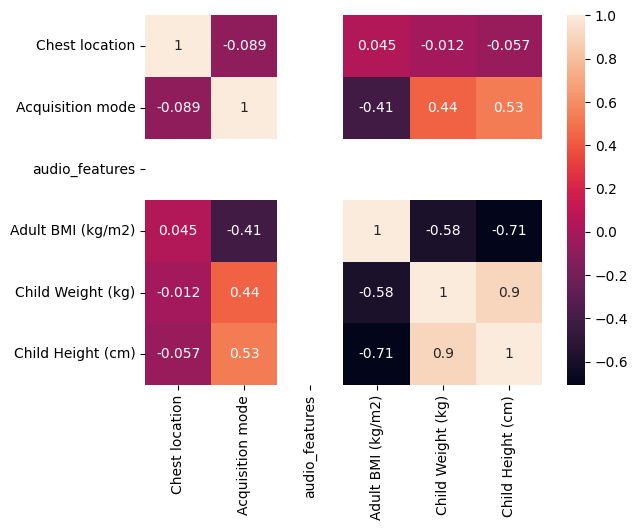

In [ ]:
corr= X.corr()
sns.heatmap(corr, annot=True)

In [ ]:
X.drop('Child Height (cm)', axis=1, inplace=True)

In [ ]:
y=to_categorical(le.fit_transform(y))
y

NameError: ignored

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=0)
### Splitting into Training and Test set

In [ ]:
num_labels=y.shape[1]
num_labels

8

In [ ]:
print(X_train.shape, '\n')
print(X_test.shape, '\n')
print(y_train.shape, '\n')
print(y_test.shape, '\n')


(644, 5) 

(276, 5) 

(644, 8) 

(276, 8) 



In [ ]:
col=X_train.shape[1]
### mking the ANN model

In [ ]:

model=Sequential()
###first layer
model.add(Dense(100,input_shape=(col,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

### compiling the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
early_stopping=keras.callbacks.EarlyStopping(
      patience=50,
      min_delta=0.001,
      restore_best_weights=True,
)

In [ ]:
### compiling the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
early_stopping=keras.callbacks.EarlyStopping(
      patience=50,
      min_delta=0.001,
      restore_best_weights=True,
)


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 100)               600       
                                                                 
 activation_11 (Activation)  (None, 100)               0         
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 200)               20200     
                                                                 
 activation_12 (Activation)  (None, 200)               0         
                                                                 
 dropout_10 (Dropout)        (None, 200)               0         
                                                                 
 dense_13 (Dense)            (None, 100)              

In [ ]:
### Training the model
from datetime import datetime
start = datetime.now()
classifier=model.fit(
    X_train,
    y_train,
    batch_size=50,
    epochs=500,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1,
)
duration = datetime.now() - start
print("Training completed in time: ", duration)

### accuracy of training dataset
train_accuracy=model.evaluate(X_train,y_train,verbose=0)
print(train_accuracy[1])

### accuracy of test dataset
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

Epoch 1/500
13/13 [==============================] - 3s 33ms/step - loss: 1.7415 - accuracy: 0.6863 - val_loss: 0.6925 - val_accuracy: 0.8623
Epoch 2/500
13/13 [==============================] - 0s 11ms/step - loss: 1.1686 - accuracy: 0.8339 - val_loss: 0.4231 - val_accuracy: 0.9058
Epoch 3/500
13/13 [==============================] - 0s 10ms/step - loss: 0.8955 - accuracy: 0.8354 - val_loss: 0.4033 - val_accuracy: 0.9022
Epoch 4/500
13/13 [==============================] - 0s 10ms/step - loss: 0.8173 - accuracy: 0.8292 - val_loss: 0.4269 - val_accuracy: 0.9058
Epoch 5/500
13/13 [==============================] - 0s 11ms/step - loss: 0.6762 - accuracy: 0.8385 - val_loss: 0.4453 - val_accuracy: 0.8841
Epoch 6/500
13/13 [==============================] - 0s 13ms/step - loss: 0.6090 - accuracy: 0.8649 - val_loss: 0.4697 - val_accuracy: 0.9058
Epoch 7/500
13/13 [==============================] - 0s 12ms/step - loss: 0.6153 - accuracy: 0.8711 - val_loss: 0.4599 - val_accuracy: 0.9058
Epoch 

In [ ]:
train_accuracy=model.evaluate(X_train,y_train,verbose=0)
print(train_accuracy[1])

0.8913043737411499


In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9021739363670349


In [ ]:
sound= pd.concat([df[['audio_features']], Patient_details['disease']], axis=1)

In [ ]:
sound.isnull().sum()

audio_features    0
disease           0
dtype: int64

In [ ]:
X=sound.iloc[:, :-1]
y=sound.iloc[:, -1]

In [ ]:


X=np.array(sound['audio_features'].tolist())
y=np.array(sound['disease'].tolist())

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=-0)

In [ ]:
X_train

array([[-470.67154   ,   72.87364   ,   53.533257  , ...,    2.3369582 ,
           2.081117  ,    1.7028875 ],
       [-402.90414   ,   88.11873   ,   49.86903   , ...,    0.7078564 ,
          -0.78141654,   -1.1026623 ],
       [-420.79306   ,   78.1344    ,   54.41032   , ...,    2.5252318 ,
           2.5591185 ,    2.552331  ],
       ...,
       [-313.86914   ,  142.467     ,   41.685036  , ...,    2.0748208 ,
           1.6347474 ,    1.5868022 ],
       [-258.48904   ,  103.12852   ,   27.887259  , ...,    1.2451646 ,
           2.6909983 ,    1.0036657 ],
       [-529.4509    ,   92.160446  ,   62.550983  , ...,    2.011756  ,
           2.2303326 ,    2.4244773 ]], dtype=float32)

In [ ]:
X_train.shape

(644, 40)

In [ ]:
num_labels=y.shape[1]
num_labels

8

In [ ]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
early_stopping=keras.callbacks.EarlyStopping(
      patience=50,
      min_delta=0.001,
      restore_best_weights=True,
)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 100)               4100      
                                                                 
 activation_15 (Activation)  (None, 100)               0         
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_16 (Dense)            (None, 200)               20200     
                                                                 
 activation_16 (Activation)  (None, 200)               0         
                                                                 
 dropout_13 (Dropout)        (None, 200)               0         
                                                                 
 dense_17 (Dense)            (None, 100)              

In [ ]:
from datetime import datetime
start = datetime.now()
classifier=model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=500,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1,
)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/500
21/21 [==============================] - 2s 17ms/step - loss: 32.0057 - accuracy: 0.6320 - val_loss: 16.2324 - val_accuracy: 0.8623
Epoch 2/500
21/21 [==============================] - 0s 8ms/step - loss: 15.3264 - accuracy: 0.7500 - val_loss: 5.3746 - val_accuracy: 0.8623
Epoch 3/500
21/21 [==============================] - 0s 8ms/step - loss: 10.9305 - accuracy: 0.6879 - val_loss: 3.1198 - val_accuracy: 0.8623
Epoch 4/500
21/21 [==============================] - 0s 10ms/step - loss: 7.7446 - accuracy: 0.6755 - val_loss: 1.6064 - val_accuracy: 0.8623
Epoch 5/500
21/21 [==============================] - 0s 10ms/step - loss: 6.0090 - accuracy: 0.6941 - val_loss: 0.8592 - val_accuracy: 0.8623
Epoch 6/500
21/21 [==============================] - 0s 8ms/step - loss: 4.0986 - accuracy: 0.7220 - val_loss: 0.7030 - val_accuracy: 0.8623
Epoch 7/500
21/21 [==============================] - 0s 10ms/step - loss: 4.2345 - accuracy: 0.6941 - val_loss: 0.7155 - val_accuracy: 0.8623
Epoch

In [ ]:
train_accuracy=model.evaluate(X_train,y_train,verbose=0)
print(train_accuracy[1])

0.8850931525230408


In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8876811861991882
